In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
from data_manipulation import split_train_test_valid, get_precision, load_data
from regressions import get_ridge_prediction, ridge_regression, get_best_reg_param

## Kernel ridge regression (linear kernel)

In [3]:
DATA = load_data()

train_X, train_y, test_X, test_y, valid_X, valid_y = split_train_test_valid(DATA[0]['X_train'], DATA[0]['y_train'])
train_X.shape

(1200, 50)

In [4]:
def linear_K(x1, x2):
    return x1 @ x2.T

## Logistic 

In [5]:
K = linear_K(train_X, train_X)
K_x = linear_K(train_X, test_X)

In [ ]:
def WKRR(K, W, y, reg):
    n = K.shape[0]
    W_half = np.diag(np.sqrt(W))
    return W_half @ np.linalg.inv(W_half@K@W_half + n*reg*np.eye(n)) @ W_half @ y

In [ ]:
WKRR(K, np.ones((1200,)), train_y, 0.1).shape

In [ ]:
def sigmoid(x):
    return 1 / (1+np.exp(-x)) + 10**-5

In [ ]:
def logistic_regression(K, y, reg):
    n = K.shape[0]
    W = np.ones((n,))
    z = y
    for i in range(10):
        print(i)
        alpha = WKRR(K, W, z, reg)
        m = alpha @ K
        W = sigmoid(m) * sigmoid(-m)
        z = m + y/sigmoid(-y*m)
        
    return alpha

In [ ]:
alpha = logistic_regression(K, train_y, .00001)
pred = get_ridge_prediction(K, alpha)
get_precision(pred, train_y)

In [ ]:
get_best_reg_param(linear_K, logistic_regression, (train_X, train_y, test_X, test_y))

## SVM (Linear Kernel)

In [ ]:
from SVM import a_compute

In [ ]:
train_y

In [ ]:
def SVM_train(kernel, X, y, Lambda):
    N = y.shape[0]
    y = 2*y-1
    
    K = kernel(X,X)
    alpha = np.zeros(N)
    # we assume K is of size N,N
    value = 100000

    for n in range(1,100):
        gradient = K @ alpha - y
        potential_alpha = alpha - 1/n * gradient
        for i in range(N):
            if potential_alpha[i] * y[i] > 1. / (2. * Lambda * N):
                potential_alpha[i] = (1. / (2. * Lambda * N))
            if potential_alpha[i] * y[i] < 0.:
                potential_alpha[i] = 0.
        alpha = potential_alpha

    return alpha

def SVM_predict(X_train, X_test, alpha):
    pos_neg = np.sign(alpha @ linear_K(train_X, test_X))
    print(pos_neg)
    return (pos_neg/2+0.5).astype(int)

In [ ]:
K = linear_K(train_X, train_X)
alpha = SVM_train(linear_K, train_X, train_y, 0.1)
alpha

## Spectrum kernel 

In [6]:
from spectrum_kernel import transform_to_index_and_save, get_words, load_data_k_spectrum

In [7]:
def spectrum_kernel(x1, x2):        
    return x1 @ x2.T

## Mismatch Kernel 

In [68]:
from mismatch_kernel import get_mismatch_matrix, get_exp_mismatch_matrix

In [69]:
mismatch_matrix = get_mismatch_matrix(6,1)

In [70]:
def mismatch_kernel(x1, x2):
    return x1 @ mismatch_matrix @ x2.T

## Homemade mismatch 

In [84]:
exp_mismatch_matrix = get_exp_mismatch_matrix(6,0.4)

In [85]:
def exp_mismatch_kernel(x1, x2):
    return x1 @ exp_mismatch_matrix @ x2.T

## Substring Kernel 

In [ ]:
from substring_kernel import K_k, substring_kernel

In [ ]:
LAMBDA = 0.1
K_k(LAMBDA, 2, 'car', 'car') - 2*LAMBDA**4+LAMBDA**6 < 10**-5

In [ ]:
# This is too slow by several orders of magnitude...
K_k(0.1, 5, 
   'CAGCTTTTATCACCTTTGAGGGAAAGTCATATTAATTTAATACTGCACACACTTGTACAACAGATCTTCTTTACTATTAAAACTCAGTTTATCAAATCACA',
   'AATAACATACCCCACTCTTTCATCTCAATCAAAAATTGAAAAAGTCAAAGAATCCTGCTTTTTTGTTTTTCTCCAAGCCATTACCCCCTCTTGATCATTGC'
   )

## Final results

In [8]:
from main import train_tune_and_pred, see_variability

In [133]:
DATA = load_data_k_spectrum(6)
exp_mismatch_matrix = get_exp_mismatch_matrix(6, 0.4)

In [134]:
DATA[0]['X_train'].shape

(2000, 4096)

In [135]:
train_tune_and_pred(exp_mismatch_kernel, ridge_regression, DATA)

Dataset 0 has found a parameter (0.1) with validation precision 0.728
Dataset 1 has found a parameter (0.05) with validation precision 0.868
Dataset 2 has found a parameter (0.05) with validation precision 0.645


#### Some variability testing 

In [155]:
reg_params_per_kernel = [
    [1e-09, 1e-10, 100.],  # spectrum k=1
    [5., 5., 1e-10],  # spectrum k=2
    [.001, 1e-10, 1e-10],  # spectrum k=3
    [.5, .05, 1.],  # spectrum k=4
    [.1, .1, .5],  # spectrum k=5
    [.05, .05, .1],  # spectrum k=6
    [.005, .005, .1],  # mismatch k=4, m=1
    [.005, .005, .01],  # mismatch k=5, m=1
    [.5, 1., .5],  # mismatch k=6, m=1
    [5., 5., 5.],  # mismatch k=6, m=2
    [.1, .05, .1],  # exp-mismatch k=4
    [.5, .1, .5],  # exp-mismatch k=5
    [.1, .05, .05],  # exp-mismatch k=6
]

In [156]:
N = len(reg_params_per_kernel)
res = np.zeros((3, 10, N))

In [157]:
# Spectrum kernels
for k in range(6):
    res[:,:,k] = see_variability(spectrum_kernel, 
                                 ridge_regression, 
                                 load_data_k_spectrum(k+1), 
                                 reg_params_per_kernel[k])

0
1
2
[ 0.50575  0.63225  0.52125]
0
1
2
[ 0.52875  0.655    0.5195 ]
0
1
2
[ 0.66175  0.736    0.6305 ]
0
1
2
[ 0.7205  0.839   0.6395]
0
1
2
[ 0.72475  0.847    0.63375]
0
1
2
[ 0.7225   0.86775  0.616  ]


In [158]:
# Mismatch kernels
for k in range(4,7):
    n_th_kernel = k+6-4
    print(n_th_kernel)
    mismatch_matrix =  get_mismatch_matrix(k, 1)
    res[:,:,n_th_kernel] = see_variability(mismatch_kernel, 
                                           ridge_regression, 
                                           load_data_k_spectrum(k),
                                           reg_params_per_kernel[n_th_kernel])

6
0
1
2
[ 0.699   0.8345  0.6065]
7
0
1
2
[ 0.6675   0.77625  0.59675]
8
0
1
2
[ 0.712    0.84075  0.62325]


In [159]:
mismatch_matrix =  get_mismatch_matrix(6, 2)
n_th_kernel = 9
res[:,:,n_th_kernel] = see_variability(mismatch_kernel, 
                                       ridge_regression, 
                                       load_data_k_spectrum(6),
                                       reg_params_per_kernel[n_th_kernel])

0
1
2
[ 0.66325  0.726    0.60575]


In [160]:
# Exp-mismatch kernels
for k in range(4,7):
    n_th_kernel = k+10-4
    print(n_th_kernel, reg_params_per_kernel[n_th_kernel])
    exp_mismatch_matrix = get_exp_mismatch_matrix(k, 0.4)
    res[:,:,n_th_kernel] = see_variability(exp_mismatch_kernel, 
                                           ridge_regression, 
                                           load_data_k_spectrum(k), 
                                           reg_params_per_kernel[n_th_kernel])

10 [0.1, 0.05, 0.1]
0
1
2
[ 0.7255   0.852    0.63025]
11 [0.5, 0.1, 0.5]
0
1
2
[ 0.72175  0.867    0.63275]
12 [0.1, 0.05, 0.05]
0
1
2
[ 0.739    0.86075  0.6475 ]


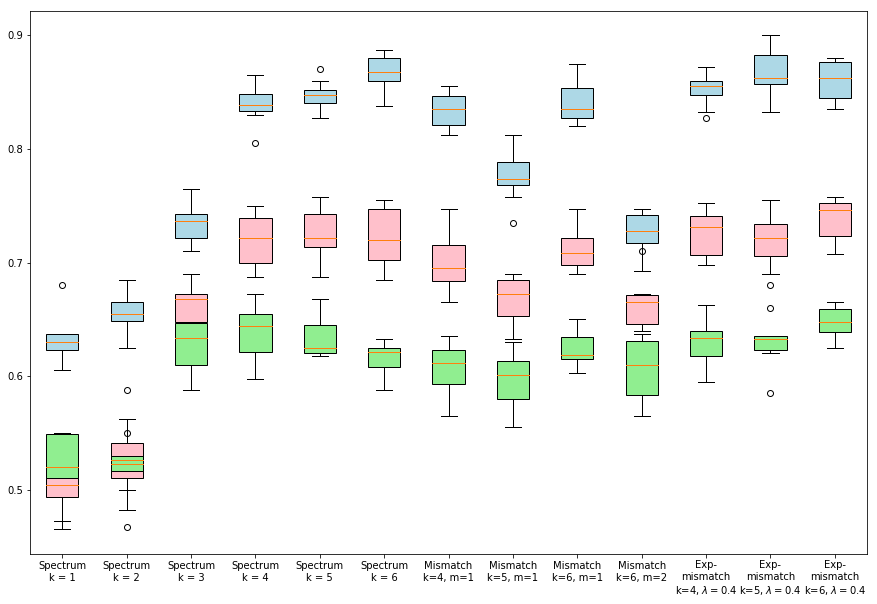

In [161]:
colors = ['pink', 'lightblue', 'lightgreen']
for k in range(3):
    bplot = plt.boxplot(res[k,:,:], 
                        patch_artist=True)
    for box in bplot['boxes']:
        box.set_facecolor(colors[k])
ind = np.arange(1, N+1)
plt.xticks(ind, 
           ['Spectrum\nk = %s' % k for k in range(1,7)] 
           + ['Mismatch\nk=%s, m=1' % k for k in range(4,7)] 
           + ['Mismatch\nk=6, m=2'] 
           + ['Exp-\nmismatch\nk=%s, $\lambda=0.4$' % k for k in range(4,7)]
          )
plt.show()